# CNN Interpretation - Sensitive Area Detection

Note: This notebook is desinged to run with Python3 and GPU runtime.<br>

Modified for local (off-line) mode with Python 3.x, TensorFlow 1.x (or 2.x), with or without GPU<br>
2020/02/04: By H.Nishiyama<br>

This notebook rewrite for local (off-line) TensorFlow 1.x (or 2.x).<br>
*If you use on online-colaboratory system, remove "###" from the top of lines in code cells. <br>
Original notebook uses TensorFlow 2.x.

In [1]:
###%tensorflow_version 2.x

####[CIS-01]
Import modules and set a random seed.<br>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.datasets import mnist
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

####[CIS-02]
Define a function to detect the sensitive areas in the second filters against the input image, and generate a heatmap.

In [3]:
def get_heatmap(model, last_conv_layer, target_image):
    target_image = target_image.reshape(1, 28*28)
    pred_output = model.output[:, np.argmax(model.predict(target_image))]
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    get_vals = K.function([model.input],
                          [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_val, conv_layer_output_val = get_vals([target_image])

    heatmap = np.zeros([14, 14])
    for i in range(last_conv_layer.output.shape[-1]):
        if pooled_grads_val[i] > 0:
            heatmap += conv_layer_output_val[:, :, i] * pooled_grads_val[i]
    heatmap /= np.max(heatmap)

    heatmap2 = np.uint8(255 * cv2.resize(heatmap, (28, 28)))
    heatmap2 = cv2.applyColorMap(heatmap2, cv2.COLORMAP_JET)
    target_image2 = np.uint8(255 * target_image.reshape(28, 28))
    target_image2 = cv2.applyColorMap(target_image2, cv2.COLORMAP_BONE)
    superimposed_img = heatmap2 + target_image2 * 0.6
    cv2.imwrite('/tmp/result.jpg', superimposed_img)

    return heatmap, preprocessing.image.load_img('/tmp/result.jpg')

####[CIS-03]
Download the MNIST dataset and store into NumPy arrays.

In [4]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(
                  (len(train_images), 784)).astype('float32') / 255
test_images = test_images.reshape(
                  (len(test_images), 784)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

####[CIS-04]
Modified to local (off-line) system.<br>
Original: Mount your Google Drive on `/content/gdrive`.<br>
Modified: Nothing.

In [5]:
###from google.colab import drive
###drive.mount('/content/gdrive')

####[CIS-05]
Modified to local (off-line) system.<br>
Original: Confirm that the exported model file `MNIST_double.hd5` is on your Google Drive.<br>
Modified: Confirm that the exported model file `MNIST_double.hd5` is on your c:\tmp\ directory.

In [6]:
###!ls -lh '/content/gdrive/My Drive/MNIST_double.hd5'
# For local (off-line) mode, use /tmp/ dir.
# If you use on online-colaboratory system, comment out the next line.
!dir \tmp\MNIST_double.hd5

 ドライブ C のボリューム ラベルは XXXX です
 ボリューム シリアル番号は XXXX-XXXX です

 C:\tmp のディレクトリ

2020/02/09  15:59        39,340,992 MNIST_double.hd5
               1 個のファイル          39,340,992 バイト
               0 個のディレクトリ  412,448,313,344 バイトの空き領域


####[CIS-06]
Restore the model from the exported model file.<br>
Modified to local (off-line) system.<br>
*Waring will be occured for some version of TensorFlow as follows;<br>
WARNING:tensorflow:From ...

In [7]:
###model = models.load_model('/content/gdrive/My Drive/MNIST_double.hd5')
# For local (off-line) mode, using /tmp/ dir.
# If you use on online-colaboratory system, comment out the next line.
model = models.load_model('/tmp/MNIST_double.hd5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter1 (Conv2D)        (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 14, 14, 32)        0         
_________________________________________________________________
conv_filter2 (Con

####[CIS-07]
Show heatmaps for sample images.

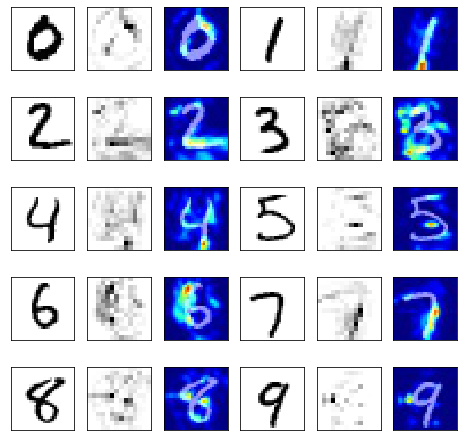

In [8]:
fig = plt.figure(figsize=(8, 8))
last_conv_layer = model.get_layer('conv_filter2')  
i = 1
for img in test_images[[3, 5, 1, 32, 4, 15, 21, 254, 84, 12]]:
    heatmap, superimposed = get_heatmap(model, last_conv_layer, img)

    subplot = fig.add_subplot(5, 6, i)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(heatmap, vmin=0, vmax=1, cmap=plt.cm.gray_r)

    subplot = fig.add_subplot(5, 6, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(superimposed)
  
    i += 3